In [3]:
import os, time
from copy import deepcopy
import numpy as np
import pickle
from sklearn.decomposition import PCA
from tqdm import tqdm

# Pytorch
import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
from torch.optim import Adam, SGD

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from style import colors
from fig_specs import *

# Custom
from helpers import copy_sd, res_to_cpu
from rnn_model_dt import RNN_Net
from task_generators import cycling as task_generator
task_name = "cycling"

Use cpu.


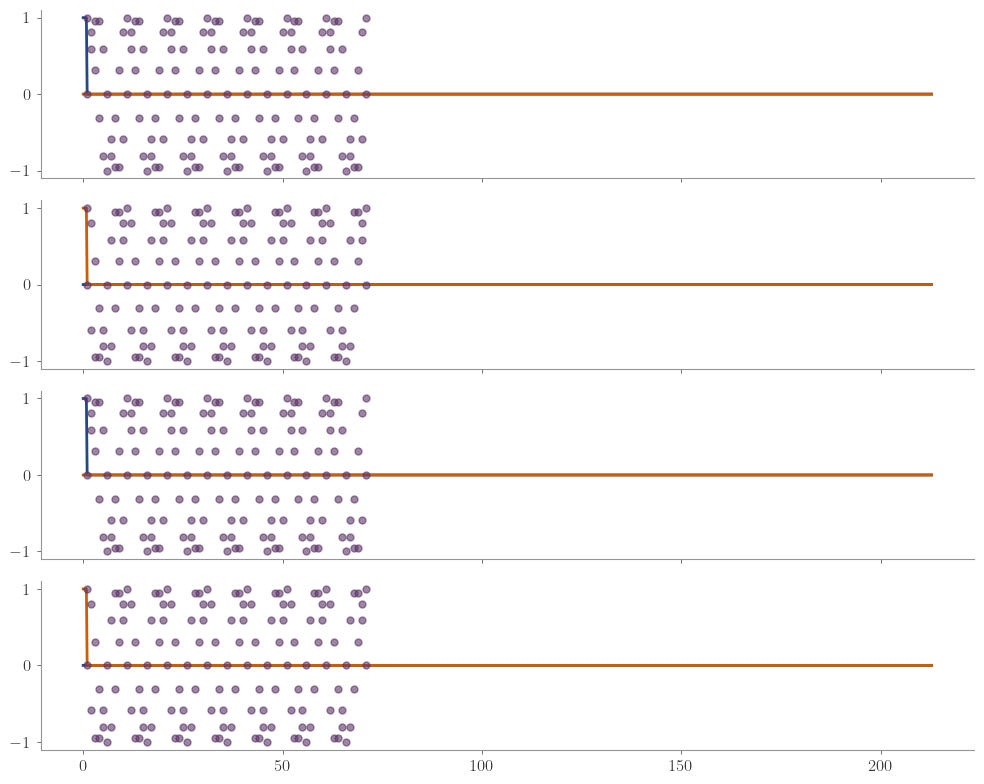

In [4]:
# Parameters
n_samples = 1

# Network
dim_in = 2
dim_hid = 256
dim_out = 2
n_layers = 2
bias = False
train_in = False
train_hid = True
train_out = False
train_layers = [train_in, train_hid, train_out]
nonlin = torch.nn.Tanh()
gaussian_init = True
h_0_std = 1.
dt = 0.2
rec_step_dt = 1
mask_step_dt = 5
batch_size = 32
t_dec = 71 
freq = 0.1
task_params = dict(
    rec_step_dt=rec_step_dt,
    mask_step_dt=mask_step_dt,
    t_dec=t_dec,
    freq=freq,
)
# Noise on input, h_0, and hidden states
noise_input_std = 0.0
noise_init_std = 1.0
noise_hid_std = 0.2

# Joint scenarios
out_scales = ['large', 'small']
gs = [1.5, 1.5]
lr0s = [0.1, 0.1] 
n_sce = len(out_scales)
opt_gens = [Adam]*n_sce
n_mi = n_samples, n_sce

n_steps = 5000
n_rec_steps = n_steps // 50

# Task generators and fixed eval task
task_gen = task_generator(dim_in, dim_out, dt, **task_params)
task_params_ev = deepcopy(task_params)
task_params_ev["t_max"] = t_dec * 3
task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
noise_input_ev = noise_input_std * np.float32(np.random.randn(*input_ev.shape)) / np.sqrt(dt)
noise_init_ev = noise_init_std * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
n_t_ev = len(ts_ev)
task_ev = ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev

# Plot the task
n_show = min(4, batch_size)
n_cols = 1
n_rows = n_show
fig = plt.figure(figsize=(10, 2 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)
for i_b in range(n_show):
    ax = axes[i_b, 0]
    # Input
    for i_in in range(dim_in):
        ax.plot(ts_ev, (input_ev + noise_input_ev)[i_b, :, i_in], "-", c=colors[i_in])
    # Target
    for i_out in range(dim_out):
        c = colors[4]
        m = mask_ev[i_b, :, i_out]
        ax.plot(ts_ev[m], target_ev[i_b, :, i_out][m], 'o', ms=5, c=c, alpha=0.6)

fig.tight_layout()
style.fixticks(fig)
plt.show()

In [ ]:
##############################################################################
# Train networks
# Loss
loss_crit = torch.nn.MSELoss()

# Results arrays
n_if = 2
n_ifn = 4
steps = torch.arange(n_steps)
loss_all = torch.zeros((*n_mi, n_steps))
output_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_out))
hids_all = 0#torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_hid))
h_0_all = torch.zeros((*n_mi, n_layers-1, batch_size, dim_hid))
sd_if_all = np.zeros((n_if, *n_mi), dtype=object)
w_in_norm_all = torch.zeros((*n_mi, n_steps))
w_rec_norm_all = torch.zeros((*n_mi, n_steps))
w_out_norm_all = torch.zeros((*n_mi, n_steps))
dw_out_norm_all = torch.zeros((*n_mi, n_steps))
dw_rec_norm_all = torch.zeros((*n_mi, n_steps))

rec_step_width = n_steps // n_rec_steps
rec_steps = torch.arange(0, n_steps, rec_step_width)
loss_avg_all = torch.zeros((*n_mi, n_rec_steps))

# PCA of activity for power spectra
n_comp = 10
# Discard initial transient for PCA
t_pc_min = 10
n_t_pc_min = int(t_pc_min / (dt * rec_step_dt))
n_t_pc = n_t_ev - n_t_pc_min
# Frequencies for FFT
dt_rec = rec_step_dt * dt
freqs = np.fft.fftfreq(n_t_pc, dt_rec)
mf = freqs >= 0
freqs = freqs[mf]
n_f = len(freqs)
h_proj_all = np.zeros((*n_mi, n_rec_steps, batch_size, n_t_pc, n_comp))
ps_all = np.zeros((n_samples, n_sce, n_rec_steps, batch_size, n_f, n_comp))

# Task to device
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))
ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = [to_dev(arr) for arr in task_ev]

# Run
time0 = time.time()
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    out_scale = out_scales[i_sce]
    g = gs[i_sce]
    lr0 = lr0s[i_sce]
    opt_gen = opt_gens[i_sce]
    # Network instance
    net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                  dt, rec_step_dt, train_layers)
    net.to(device)
    # Initial state: the same for each batch!
    h_0 = h_0_std * torch.randn((n_layers - 1, 1, dim_hid), device=device)
    h_0 = torch.tile(h_0, (1, batch_size, 1))
    h_0_all[mi] = h_0.detach()

    # Optimizer
    if opt_gen == torch.optim.Adam:
        lr = lr0 / dim_hid
    else:
        lr = lr0
    opt = opt_gen(net.parameters(), lr=lr)

    # Save before training
    sd_if_all[0][mi]= copy_sd(net.state_dict)
    with torch.no_grad():
        # With noise
        output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                       h_0 + noise_init_ev, 
                                       noise_hid_std, last_time=False)
        output_all[0][mi] = output
        # No noise
        output, hids = net.forward_hid(input_ev, h_0, last_time=False)
        output_all[2][mi] = output

    # Train
    for step in tqdm(range(n_steps)):
        # Record
        # 500 iterations took 24 sec each without recording; 32 sec with
        with torch.no_grad():
            # Norm of weight changes
            w_in = net.rnn.weight_ih_l0
            w_rec = net.rnn.weight_hh_l0
            w_out = net.decoder.weight
            w_in_norm_all[mi][step] = torch.linalg.norm(w_in).item()
            w_rec_norm_all[mi][step] = torch.linalg.norm(w_rec).item()
            w_out_norm_all[mi][step] = torch.linalg.norm(w_out).item()
            dw_out_norm_all[mi][step] = torch.linalg.norm(
                w_out - sd_if_all[0][mi]["decoder.weight"]).item()
            dw_rec_norm_all[mi][step] = torch.linalg.norm(
                w_rec - sd_if_all[0][mi]["rnn.weight_hh_l0"]).item()
            if step % rec_step_width == 0:
                rec_step = step // rec_step_width
                output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                               h_0 + noise_init_ev, 
                                               noise_hid_std, last_time=False)
                # Loss for the batch-averaged output. This is a bit tricky, because the targe depends on i_b
                diffs_avg = (output - target_ev).mean(0)[mask_ev[0]]
                loss = loss_crit(diffs_avg, 0. * diffs_avg)
                loss_avg_all[mi][rec_step] = loss
                
                # First components of PCA
                h = hids[0, :, n_t_pc_min:].reshape(batch_size * n_t_pc, dim_hid).cpu()
                pca = PCA(n_comp)
                pca.fit(h)
                h_proj = pca.transform(h).reshape(batch_size, n_t_pc, n_comp)
                # Power spectra via FFT
                ps = np.abs(np.fft.fft(h_proj, axis=-2)[:, mf, :])**2
                h_proj_all[mi][rec_step] = h_proj
                ps_all[mi][rec_step] = ps

        opt.zero_grad()
        # Draw an independent task each time
        task = task_gen(batch_size)
        _, input, target, mask = [to_dev(arr) for arr in task]
        # Draw independent input noise every time!
        noise_init = noise_init_std * torch.randn_like(h_0)
        noise_input = noise_input_std * torch.randn_like(input) / np.sqrt(dt)
        output = net(input + noise_input, h_0 + noise_init, noise_hid_std)
        loss = loss_crit(output[mask], target[mask])
        loss.backward()
        opt.step()
        loss_all[mi][step] = loss.item()

    # Save after training
    sd_if_all[1][mi] = copy_sd(net.state_dict)
    with torch.no_grad():
        # With noise
        output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                       h_0 + noise_init_ev, 
                                       noise_hid_std, last_time=False)
        output_all[1][mi] = output
        # No noise
        output, hids = net.forward_hid(input_ev, h_0, last_time=False)
        output_all[3][mi] = output
        # hids_all[3][mi] = hids[0]
print("Took %.1f sec." % (time.time() - time0))

#######################################################################################
# Move everything to cpu!
res_list = [sd_if_all]
res_to_cpu(res_list)

# Save
save_data = True
if save_data:
    res = [
        n_steps, n_samples, gs, out_scales, n_sce, opt_gens, lr0s, n_mi, dim_hid, dim_in, dim_out, 
        dt, rec_step_dt, n_layers, bias, train_in, train_hid, train_out, train_layers, nonlin, 
        gaussian_init, h_0_std, noise_input_std, noise_init_std, noise_hid_std, batch_size, 
        task_params, task_params_ev, n_t_ev, task_ev, n_if, n_ifn, steps, 
        loss_all, output_all, hids_all, h_0_all, sd_if_all, 
        n_rec_steps, rec_step_width, rec_steps, loss_avg_all, 
        w_in_norm_all, w_rec_norm_all, w_out_norm_all,
        dw_out_norm_all, dw_rec_norm_all, 
        h_proj_all, ps_all,
    ]
    # Save data
    file_name = "cycling" + "_n_%d_train_rec_only" % dim_hid
    file_name = "_".join(file_name.split('.'))
    data_file = data_path + file_name + ".pkl"
    with open(data_file, 'wb') as handle:
        pickle.dump(res, handle)
    print('Saved to ', data_file)

  0%|▏                                                                 | 15/5000 [00:07<35:18,  2.35it/s]